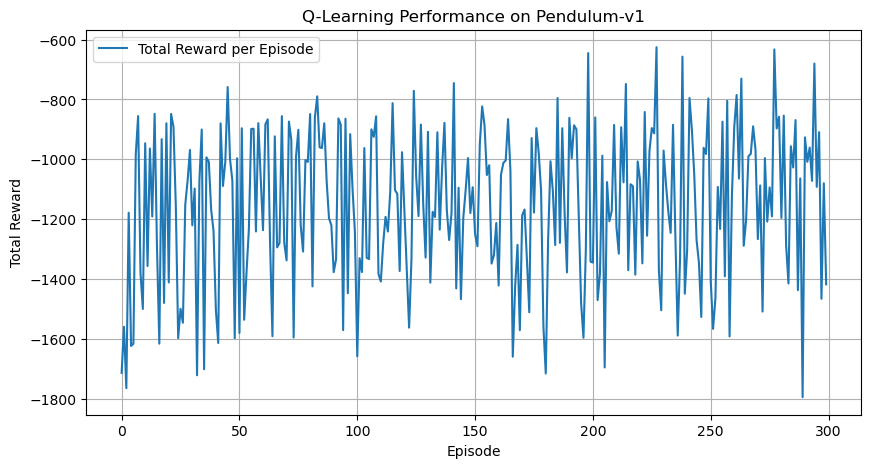

In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Seed for randomness
seed = int(time.time()) % 2**32
np.random.seed(seed)
random.seed(seed)

# Training environment (no rendering for performance)
train_env = gym.make("Pendulum-v1")
obs_space_low = train_env.observation_space.low
obs_space_high = train_env.observation_space.high

# Discretization settings
n_bins = (10, 10, 10)
obs_bins = [np.linspace(low, high, bins) for low, high, bins in zip(obs_space_low, obs_space_high, n_bins)]
n_actions = 5  # Discretize action into 5 torque values
discrete_actions = np.linspace(-2, 2, n_actions)

# Initialize Q-table
Q = np.zeros(n_bins + (n_actions,))

# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
episodes = 300
max_steps = 200

# Discretization helper
def discretize(obs):
    indices = []
    for i, val in enumerate(obs):
        idx = np.digitize(val, obs_bins[i]) - 1
        idx = min(max(idx, 0), n_bins[i]-1)
        indices.append(idx)
    return tuple(indices)

# Training
rewards = []
for episode in range(episodes):
    state, _ = train_env.reset(seed=seed + episode)
    state = discretize(state)
    total_reward = 0

    for step in range(max_steps):
        if random.uniform(0, 1) < epsilon:
            action_idx = random.randint(0, n_actions - 1)
        else:
            action_idx = np.argmax(Q[state])

        action = [discrete_actions[action_idx]]
        next_state_cont, reward, terminated, truncated, _ = train_env.step(action)
        next_state = discretize(next_state_cont)

        best_next_action = np.max(Q[next_state])
        Q[state + (action_idx,)] += alpha * (reward + gamma * best_next_action - Q[state + (action_idx,)])
        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards.append(total_reward)

train_env.close()

# Plot training performance
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning Performance on Pendulum-v1")
plt.legend()
plt.grid(True)
plt.show()

# Test the trained agent with rendering
test_env = gym.make("Pendulum-v1", render_mode="human")
state, _ = test_env.reset(seed=seed + 999)
state = discretize(state)

for step in range(max_steps):
    action_idx = np.argmax(Q[state])
    action = [discrete_actions[action_idx]]
    next_state, reward, terminated, truncated, _ = test_env.step(action)
    next_state = discretize(next_state)
    state = next_state
    if terminated or truncated:
        break

test_env.close()